# Processing Elmer/Ice output

### Felicity Holmes

## General Project Description

For my PhD project, I use an ice-sheet model called Elmer/Ice. Specifcally, I am simulating the glacier Kronebreen, Svalbard for the time period 2016 - 2017 and comparing the output to observational data in order to evaluate the applicability of Elmer/Ice in this location. The long-term goal is to use the tuned model to simulate the development of the glacier until 2100. 

After each simulation, I have the following output:

1) A .csv file with point data for various variables (e.g. velocity, pressure, elevation) at each timestep

2) A .dat file for each partition containing the mean velocity value after each timestep. Of particular interest is partition 0, which covers the front (and most dynamically exciting) part of the glacier. 

For the project, I want to explore this data and build up a processing chain that I can use to analyse the output. My current simulations in Elmer/Ice are not final as I am still tuning parameters etc, but I use my 'best yet' output for this project. This means that any conclusions drawn from the analysis are only preliminary, but provide a framework for exploration and analysis of the output.

Specifically, my aims are:
1) To convert the point data into a raster than I can then compare to observations. This would allow me to identify whether the model is performing well and highlight any areas of particulary good or bad performance. 

2) To look at the time series of mean velocities and understand how important surface mass balance (and its constituent components) are with regards to determining velocities. In order to do this, I want to explore the utility of a few techniques such as dynamic time warping and a random forest regressor.

I will split up this report into parts 1 and 2; part 1 will deal with the point data (mainly geocomputation) and part 2 will deal with the data from the frontal partition (geocomputation and modelling).

## Part 1: Point data exploration

Although it is possible to export a .csv file for every timestep, I have opted to focus on the final timestep for this project. The initial conditions for the glacier are derived from observations, so it is of interest to see if the modelled and observed development of the glacier are similar. Although it would be of interest to conduct this analysis at regular intervals (e.g. once a month), the output that I am using for this project is preliminary and only spans 52 days. Therefore, this project will only compare the final model output to the appropriate observational data but forms a basis for more comprehensive analysis in the future.

The .csv data is 3D with data being provided for the entire depth of the glacier. However, I am primarily interested in the surface values as the observational data only shows surface properties. The first steps are therefore to:

1) Extract all the data when 'depth <  5'. I am using depth < 5 rather than depth == 0 as the surface nodes do not always lie precisely at 0m depth due to mesh evolution

2) Investigate the available variables and the number of data points

In [13]:
%%bash 

# Extract surface data. Using depth < 5 rather than depth == 0 as some surface nodes
# are not exactly 0
awk '{if ($0<5) print}' "./inputs/calving_elmer_output.txt" > ./outputs/depth0_calvingVariables.txt

head -n 1 ./outputs/depth0_calvingVariables.txt

wc -l ./outputs/depth0_calvingVariables.txt

tail -n 1 ./outputs/depth0_calvingVariables.txt | grep -o " " | wc -l

"depth" "temperature homologous" "smb" "velocity:0" "velocity:1" "velocity:2" "frontadvance:0" "frontadvance:1" "frontadvance:2" "calving:0" "calving:1" "calving:2" "Points:0" "Points:1" "Points:2"
8330 ./outputs/depth0_calvingVariables.txt
14


It appears that the velocity variables are given in x, y, z but I would like to calculate the magnitude. 

The next step is therefore to calculate the magnitude of velocity in 2D (just taking into account velocity in the x and y directions).

In [14]:
import numpy as np
import sys 

# Get the header line and add 'velocity_magnitude', then save this as a file

fp=open('./outputs/depth0_calvingVariables.txt')
header = fp.readline().strip().split(' ')
header.append("velocity_magnitude")
np.savetxt('./outputs/calvingData_names.txt', header, delimiter=",", fmt="%s")

# Calculate the velocity magnitude and append to dataset

dataset = np.genfromtxt('./outputs/depth0_calvingVariables.txt', skip_header=1)
temp=[]

for row in dataset:
    velocity_mag = np.sqrt((float(row[3]))**2+(float(row[4])**2)) 
    temp.append(velocity_mag)

temp_array = np.array(temp).reshape(8329,1)

# Save the new datatset

result = np.append(dataset, temp_array, axis=1)   
np.savetxt('./outputs/calving_velocity_mag.csv', result, delimiter=",", fmt="%s")

In order to double check that the operation was successful, the number of columns will be counted and the first few lines of data will be printed.

In [15]:
%%bash

tail -n 1 ./outputs/depth0_calvingVariables.txt | grep -o " " | wc -l

tail -n 1 ./outputs/calving_velocity_mag.csv | grep -o "," | wc -l

head ./outputs/calving_velocity_mag.csv

14
15
129.01,0.0,0.0,0.0,0.0,0.0,5.3266e-11,-5.3521e-11,-1.2158e-12,0.0,0.0,0.0,448350.0,8758700.0,7.1788,0.0
192.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449270.0,8758200.0,6.9542,0.0
177.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,448800.0,8758500.0,10.856,0.0
148.28,0.0,0.0,-781.79,782.08,20.19,-2.3741,2.3852,0.054103,0.0,0.0,0.0,448300.0,8758600.0,-1.6698e-09,1105.823100907193
151.78,0.0,0.0,-1938.0,1134.2,-8.5292e-08,-5.922,3.506,1.2153e-10,0.0,0.0,0.0,448200.0,8758100.0,4.1405e-11,2245.4963014888267
162.41,0.0,0.0,-1073.8,993.68,-4.7606e-08,-3.2781,3.0476,6.7156e-11,0.0,0.0,0.0,448270.0,8758400.0,-2.3167e-12,1463.0264462408054
161.58,0.0,0.0,-1258.8,1170.4,-5.7489e-08,-3.8313,3.5924,7.3778e-11,0.0,0.0,0.0,448200.0,8758400.0,-2.2002e-11,1718.840772148485
152.99,0.0,0.0,-1741.2,1127.1,-7.164e-08,-5.3043,3.4774,1.2594e-10,0.0,0.0,0.0,448210.0,8758200.0,2.8983e-10,2074.1581063168737
155.49,0.0,0.0,-936.15,881.14,-5.2037e-08,-2.8785,2.6741,7.6945e-11,0.0,0.0,0.0,448290.0,8758

To get a coherent view of what the velocities look like across the glacier, I want to convert the point data into a raster. 

This can be done using gdal_grid but, in order to do this, a vrt header must be made for the data file.

In [16]:
%%bash 

cat ./inputs/calving_velocity_mag.vrt

<OGRVRTDataSource>
    <OGRVRTLayer name="calving_velocity_mag">
        <SrcDataSource>CSV:./outputs/calving_velocity_mag.csv</SrcDataSource>
        <GeometryType>wkbPoint</GeometryType>
        <GeometryField encoding="PointFromColumns" x="field_13" y="field_14" z="field_16"/>
    </OGRVRTLayer>
</OGRVRTDataSource>

The raster can now be created using gdal_grid. 

There are a number of different options available with regards to the interpolation algorithm. For this project, I have chosen to use the inverse distance to a power ('invdist') algorithm, which is a weighted average interpolator. 

Both the weighting power 'p' and the smoothing parameter 's' can be user defined. As velocities across a glacier do not vary abruptly, I have opted for a high smoothing paramater of 500.

The raster is then clipped by extent using a shapefile that covers the area of Kronebreen (via gdalwarp), before being visualised using openev.

In [17]:
%%bash 
        
gdal_grid -a invdist:power=1.0:smoothing=500.0 -outsize 400 400 -of GTiff -ot Float64 -l \
        calving_velocity_mag ./inputs/calving_velocity_mag.vrt ./outputs/calving_velocity_mag.tiff

gdalwarp -overwrite -cutline ./inputs/Domain.shp -crop_to_cutline -s_srs EPSG:32633 -t_srs EPSG:32633 \
        ./outputs/calving_velocity_mag.tiff ./outputs/cropped_calving_velocity_mag.tiff -dstnodata 9999

/usr/bin/openev/bin/openev ./outputs/cropped_calving_velocity_mag.tiff 

Grid data type is "Float64"
Grid size = (400 400).
Corner coordinates = (447926.775000 8764912.375000)-(466553.225000 8754987.625000).
Grid cell size = (46.450000 24.750000).
Source point count = 8329.
Algorithm name: "invdist".
Options are "power=1.000000:smoothing=500.000000:radius1=0.000000:radius2=0.000000:angle=0.000000:max_points=0:min_points=0:nodata=0.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 522P x 279L.
Processing ./outputs/calving_velocity_mag.tiff [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Default software rendering mode (use -h if accelerated video card installed).
Loading tools from /usr/bin/openev/tools/Tool_DriverList.py
Loading tools from /usr/bin/openev/tools/Tool_Export.py
Loading tools from /usr/bin/openev/tools/Tool_ShapesGrid.py


These modelled velocities are now ready to be compared to the observed velocities, which are also provided as a .tiff. 

For this operation, I use gdal_calc to subtract one raster from the other and thus create a map of difference. I first use gdalwarp to make sure the two rasters have the same extent and resample the rasters so the pixel size is consistent.

The extents are still slightly different, but this can be worked around by using the --extent flag in gdal_calc. It is notable that the two rasters have different units; observations are given in m/day whereas the modelled velocities are in m/year. The observed velocities are therefore multiplied by 365.25 within gdal_calc. 

In [18]:
%%bash

gdalwarp -overwrite -cutline ./inputs/Domain.shp -crop_to_cutline -s_srs EPSG:32633 -t_srs EPSG:32633 \
./inputs/kroneVelo_Observed.tif ./outputs/kroneVelo_Observed_crop.tiff -dstnodata 9999

gdalwarp -tr 10 -10 ./outputs/kroneVelo_Observed_crop.tiff ./outputs/kroneVelo_Observed_crop_resample.tiff
gdalwarp -tr 10 -10 ./outputs/cropped_calving_velocity_mag.tiff ./outputs/cropped_calving_velocity_mag_resample.tiff

gdal_calc.py -A ./outputs/cropped_calving_velocity_mag_resample.tiff  -B ./outputs/kroneVelo_Observed_crop_resample.tiff  \
--outfile=./outputs/model_obs_comparison.tif --calc="A-(B*365.25)" --extent="intersect"

/usr/bin/openev/bin/openev ./outputs/model_obs_comparison.tif
        
        

Creating output file that is 6309P x 3362L.
Processing ./inputs/kroneVelo_Observed.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ./inputs/kroneVelo_Observed.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1863P x 993L.
Processing ./outputs/kroneVelo_Observed_crop.tiff [1/1] : 0Using internal nodata values (e.g. 9999) for image ./outputs/kroneVelo_Observed_crop.tiff.
Copying nodata values from source ./outputs/kroneVelo_Observed_crop.tiff to destination ./outputs/kroneVelo_Observed_crop_resample.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1859P x 993L.
Processing ./outputs/cropped_calving_velocity_mag.tiff [1/1] : 0Using internal nodata values (e.g. 9999) for image ./outputs/cropped_calving_velocity_mag.tiff.
Copying nodata values from source ./outputs/cropped_calving_velocity_mag.tiff to destination ./outputs/cropped_calving_velocity_mag_resample.tiff.
...10...20...30...40...

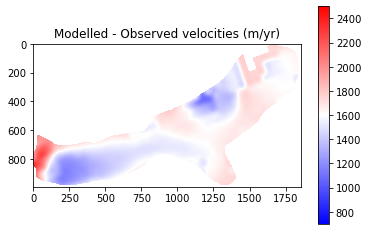

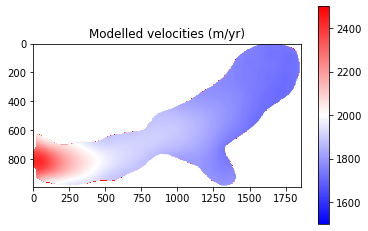

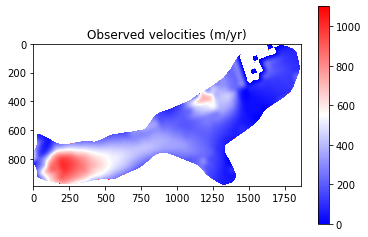

In [19]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot
from matplotlib import colors, cm
import numpy as np

diff = rasterio.open("./outputs/model_obs_comparison.tif")
modelled = rasterio.open("./outputs/cropped_calving_velocity_mag_resample.tiff")
observed = rasterio.open("./outputs/kroneVelo_Observed_crop_resample.tiff")

cmap = cm.bwr.copy()
cmap.set_over('w',1.)
cmap.set_under('w',1.)

pyplot.imshow(diff.read(1), vmin=700, vmax=2500, cmap=cmap)
pyplot.colorbar()
pyplot.title('Modelled - Observed velocities (m/yr)')
pyplot.show()

pyplot.imshow(modelled.read(1), vmin=1500, vmax=2500, cmap=cmap)
pyplot.colorbar()
pyplot.title('Modelled velocities (m/yr)')
pyplot.show()

pyplot.imshow((observed.read(1))*365.25, vmin=0, vmax=1100, cmap=cmap)
pyplot.colorbar()
pyplot.title('Observed velocities (m/yr)')
pyplot.show()

The final results from Part 1 show that modelled velocities are systematically higher than the observed velocities. This suggests that there may be an issue with a parameter such as basal friction or ice viscosity. It should be noted that some of the differences are explainable:

1) The very front of the glacier shows very low velocities. This is due to the retreat of the glacier and so this area should be ignored
2) Observed velocities contain error (est. up to 150 m/yr). This is particlarly true for slow flowing regions where little change occurs being subsequent satellite images. Therefore, we expect greater error over the upper parts of the glacier and place less emphasis on getting perfect correspondaance here.

Despite this, the above analysis is of great help in terms of tuning and evaluating my ice sheet model set-up and has identified that I need to look into why the glacier is flowing faster than expected.

## Part 2: Time series of Velocity and Surface Mass Balance

I want to analyse a time series of frontal velocities from Kronebreen, Svalbard.

I have configured the Elmer/Ice model to output the average velocity for each partition, with partition 0 corresponding to the frontal section of the glacier. As this is the most dynamic and interesting part of the glacier, it is this area that will be focused on for this project. 

I first want to explore the data files and then begin with a simple visualisation of how velocity varies throughout the simulation.

The data files do not have headers, but a separate file 'calving_averages.dat.names' provides a list of the variables included.

In [20]:
%%bash 

# View the metadata - variable names, where the data comes from etc

cat ./inputs/calving_averages/calving_averages.dat.names

# Look at the first row of data 

head -n 1 ./inputs/calving_averages/calving_averages.dat.0

# Check the number of rows

wc -l ./inputs/calving_averages/calving_averages.dat.0

Elmer version: 9.0
Elmer revision: ae1635a
Elmer compilation date: 2021-01-20
Solver input file: krone_calving.sif
File started at: 2021/05/19 17:31:54
 
Variables in columns of matrix: ./calving_averages.dat
   1: mean: velocity 1
   2: mean: velocity 2
   3: mean: velocity 3
   4: mean: smb
   5: res: solver cpu time distance
   6: res: solver real time distance
   7: res: solver cpu time navier-stokes
   8: res: solver real time navier-stokes
   9: res: solver cpu time stresssolver
  10: res: solver real time stresssolver
  11: res: solver cpu time longitudinal mesh update
  12: res: solver real time longitudinal mesh update
  13: res: solver cpu time free surface top
  14: res: solver real time free surface top
  15: res: solver cpu time free surface bottom
  16: res: solver real time free surface bottom
  17: res: solver cpu time vertical mesh update
  18: res: solver real time vertical mesh update
  19: res: solver cpu time 3d calving
  20: res: solver real time 3d calving
  21: 

In [21]:
%%bash
# Plot velocity magnitude 

R --vanilla -q

# Prepare the data and create an array 'timesteps'
#tseries = read.table("./inputs/longSpinUP_averages/longSpinUp_averages.dat.0", sep="," , header=FALSE)
tseries = read.table("./inputs/calving_averages/calving_averages.dat.0", sep="," , header=FALSE)
head(tseries)
timesteps = t(1:52)

#Create the plot
png("./images/explore_velocities.png")
plot(x=timesteps, y=tseries$V23, pch=4, cex=2, col="red", type='l', ylab="Velocity magnitude (m/yr)", xlab="Timestep")
dev.off()

#Spare code to plot x and y velocities...
#plot(x=timesteps, y=tseries$V3, pch=4, cex=2, col="blue", xlab=("Timestep"), ylab=("Y Velocity (blue) (m/yr)"), type='l', ylim=c(-550,1000))
#par(new=T)
#plot(x=timesteps, y=tseries$V2, pch=4, cex=2, col="red", type='l', ylim=c(-3500,-600), axes=F, ylab=NA, xlab=NA)+axis(side=4)+mtext("X Velocity (red) (m/yr)", side=4,line=-1.0)

> 
> # Prepare the data and create an array 'timesteps'
> #tseries = read.table("./inputs/longSpinUP_averages/longSpinUp_averages.dat.0", sep="," , header=FALSE)
> tseries = read.table("./inputs/calving_averages/calving_averages.dat.0", sep="," , header=FALSE)
> head(tseries)
     V1     V2      V3      V4      V5      V6    V7    V8    V9   V10   V11
1 -1060 -130.0 -2490.0  -3.120 0.00807 0.01580 45.00 46.30 0.803 0.827 0.167
2 -3510  402.0   -53.7   5.930 0.00561 0.00937  5.84  6.08 0.172 0.186 0.108
3 -2160   -6.7 -2490.0   0.955 0.00351 0.00887  4.69  4.99 0.171 0.193 0.102
4 -3680  988.0   -66.2 -16.600 0.00569 0.00635  4.72  4.93 0.175 0.189 0.110
5 -3640  969.0   -70.2 -23.400 0.00503 0.00979  8.45  8.91 0.170 0.187 0.111
6 -3400  926.0   -59.0 -13.000 0.00435 0.01050  7.22  7.69 0.173 0.192 0.122
    V12    V13    V14    V15    V16    V17    V18    V19   V20   V21  V22
1 0.181 0.4620 0.5490 0.1450 0.1760 0.3540 0.3890 0.1200 0.407 2.380 3.08
2 0.118 0.0349 0.0502 0.0201 0.0278 

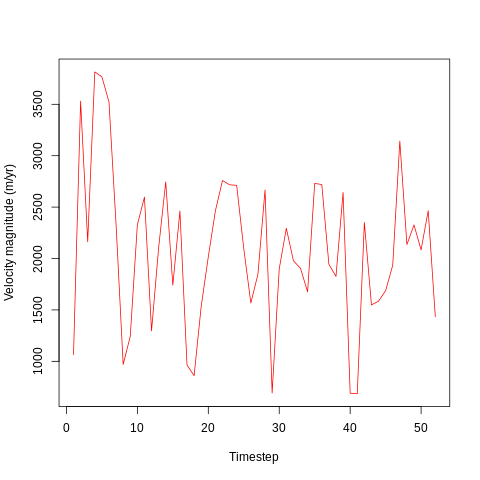

In [22]:
from IPython.display import Image
Image("./images/explore_velocities.png")

It looks like velocity begins high (c. 3500 m/yr) at the beginning of the simulation - probably due to the initial conditions imposed by the simulation. After around 5 days, the velocity drops abd begins oscillating around 2000 m/yr.

The velocity varies considerably between timesteps, with lows of 500 m/yr and highs of around 3000 m/yr. This may be due to differences in surface mass balance (SMB) or in internal dynamics due to the impacts of, for example, calving events.

Each timestep is one day, and the above plot covers a 52 day period corresponding the the first 52 days of the calendar year in 2016.

The model is forced by a surface mass balance (SMB) dataset which is calculated as follows:

SMB = PR - RU - SU - ER

where

RU = ME + RA - RF

PR is total precipitation (including snowfall and rainfall), RU is  meltwater runoff, SU is total sublimation and ER is erosion from drifting snow. Runoff is composed of liquid water from rain (RA) and melt (ME) that is not retained or refrozen in firn (RF).

I want to look into the relationship between velocity and SMB by comparing the time series of velocities with the time series of SMB. The first step in this analysis is to plot the time series against eachother and compare them qualitatively. 

The SMB data is from Noël et al. (2020), with some pre-processing having occured before use during this course project. 

In [23]:
%%bash
# Plot X velocity alongside SMB

R --vanilla -q

# Prepare the velocity and SMB data and create an array 'timesteps'
input_series = read.table("./inputs/calving_averages/calving_averages.dat.0", sep="," , header=FALSE)
timesteps = t(1:52)

#Create the plots
png("./images/velocities_SMB.png")
plot(x=timesteps, y=input_series$V23, pch=4, cex=2, col="red", type='l', ylim=c(0,4000), ylab="Velocity magnitude(red) (m/yr)", xlab="Timestep")
par(new=T)
plot(x=timesteps, y=input_series$V5, pch=4, cex=2, col="green", type='l', axes=F, ylab=NA, xlab=NA)+axis(side=4)+mtext("SMB (green) (mm w.e./yr)", side=4,line=-1.0)
dev.off()

> 
> # Prepare the velocity and SMB data and create an array 'timesteps'
> input_series = read.table("./inputs/calving_averages/calving_averages.dat.0", sep="," , header=FALSE)
> timesteps = t(1:52)
> 
> #Create the plots
> png("./images/velocities_SMB.png")
> plot(x=timesteps, y=input_series$V23, pch=4, cex=2, col="red", type='l', ylim=c(0,4000), ylab="Velocity magnitude(red) (m/yr)", xlab="Timestep")
> par(new=T)
> plot(x=timesteps, y=input_series$V5, pch=4, cex=2, col="green", type='l', axes=F, ylab=NA, xlab=NA)+axis(side=4)+mtext("SMB (green) (mm w.e./yr)", side=4,line=-1.0)
numeric(0)
> dev.off()
null device 
          1 
> 


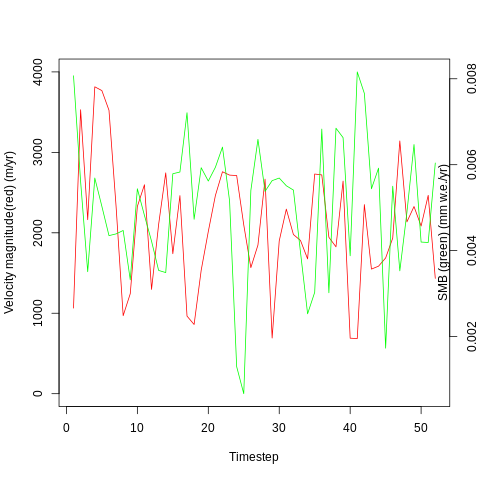

In [24]:
from IPython.display import Image
Image("./images/velocities_SMB.png")

I want to see if there is a correlation between these two time series, and will start with a simple linear regression:

In [25]:
%%bash
# Regress SMB against X velocity

R --vanilla -q

input_series = read.table("./inputs/calving_averages/calving_averages.dat.0", sep="," , header=FALSE)

regression = lm(V23 ~ V5, data = input_series)

summary(regression)


> 
> input_series = read.table("./inputs/calving_averages/calving_averages.dat.0", sep="," , header=FALSE)
> 
> regression = lm(V23 ~ V5, data = input_series)
> 
> summary(regression)

Call:
lm(formula = V23 ~ V5, data = input_series)

Residuals:
     Min       1Q   Median       3Q      Max 
-1457.71  -497.13   -53.78   452.40  1772.44 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2372.8      352.5   6.732 1.58e-08 ***
V5          -58044.9    67071.9  -0.865    0.391    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 764.8 on 50 degrees of freedom
Multiple R-squared:  0.01476,	Adjusted R-squared:  -0.004947 
F-statistic: 0.7489 on 1 and 50 DF,  p-value: 0.3909

> 


The p value is poor (0.39) and shows the result is not statistically significant. The R^2 value is low at 0.15 suggesting that there is little correlation between surface mass balance and velocity magnitude. However, this is a very simply done analysis and is conducted only as an initial data exploration.

I will now try dynamic time warping as an alternative method for comparing the two time series:

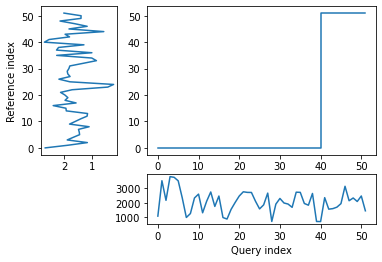

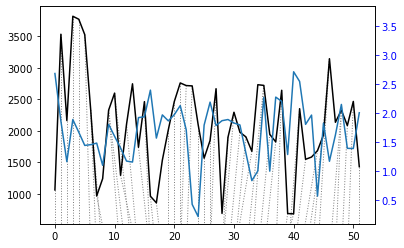

1374.9222062850727

In [26]:
import numpy as np
from dtw import *
import matplotlib.pyplot as plt

# Get the data 

query = np.loadtxt(fname="./inputs/calving_averages/calving_averages.dat.0", delimiter=',', usecols=22)
# Smb in mm w.e. per YEAR converted to ice equiv. (as used in Elmer/Ice)
reference = (np.loadtxt(fname="./inputs/calving_averages/calving_averages.dat.0", delimiter=',', usecols=4))*365.25/(1000.0/910.0)


# Perform the analysis

alignment = dtw(query, reference, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")
plt.show()

dtw(query, reference, keep_internals=True, window_type="sakoechiba", window_args={"window_size":10},
    step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="twoway",offset=-1)

alignment.normalizedDistance

The patterns of the two time series looked similar when plotted side by side but the distance between them is relatively large, which could be partially due to the very different units. 

A very close correspondance is not expected as ice dynamics do not react to external changes immediately but are partly controlled by preceding conditions. 

However, noise may still be impacting the result, and the warp path jumps (rather than being broadly diagonal) suggesting a less-than-optimal fit. In order to try and remove some noise, I will apply a wavelet transform to extract the key features of the two time series and then re-run the dynamic time warp.

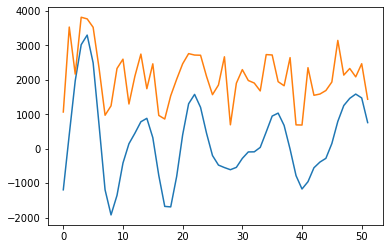

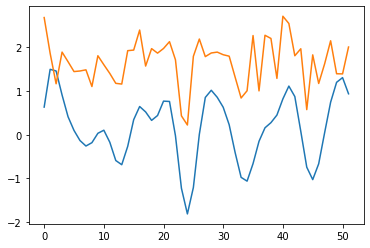

In [27]:
import pywt
# Try out wavelet feature extraction ...

#Velocity

sLst = np.arange(1, 31)
wav_transform_velocity, freqs = pywt.cwt(query, sLst, 'mexh')

plt.plot(wav_transform_velocity[1])
plt.plot(query)
plt.show()

#SMB

wav_transform_smb, freqs = pywt.cwt(reference, sLst, 'mexh')

plt.plot(wav_transform_smb[1])
plt.plot(reference)
plt.show()


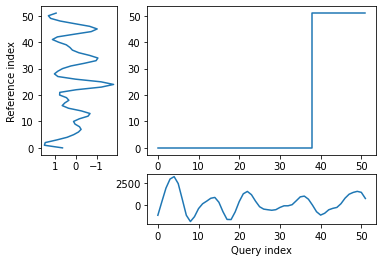

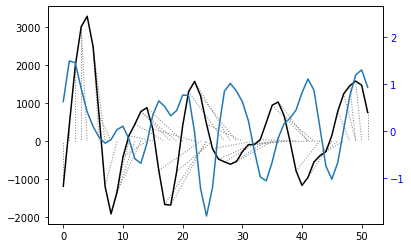

468.9828699904016

In [28]:
import numpy as np
from dtw import *
import matplotlib.pyplot as plt

# Run dynamic time warp again

alignment = dtw(wav_transform_velocity[1], wav_transform_smb[1], keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")
plt.show()

dtw(wav_transform_velocity[1], wav_transform_smb[1], keep_internals=True, window_type="sakoechiba", window_args={"window_size":10},
    step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="twoway",offset=-1)

alignment.normalizedDistance

With the wavelet pre-processing, there is a much reduced distance between the two time series (1375 vs 469), suggesting that there may some connection between the two. However, the warp path still does'nt take a consistent, diagonal path. This means that the analysis is not overly successful and other techniques may be required to investigate the relationship. 

The lack of good correspondance points to the fact that other variables besides SMB are also influencing the velocity of the glacier. These could be indirect effects of SMB (for example through thinning and thickening of the glacier in different areas altering the gravitational driving stress), or unrelated variables such as bed geometry. 

It is also notable that SMB variations are not expected to immediately cause large velocity variations, as mentioned before. However, understanding how quickly the glacier can respond to external perturbations is of interest with regards to reducing uncertainty regarding how they will behave in the future and so in improving sea level rise estimates. 

The results of the qualitative and dynamic time warp analyses show that there may be a connection between the two, although nothing significant has been identified yet.

I next want to split up SMB into its underlying components, so I can use these time series in my analysis. This will be useful for understanding whether frontal velocities are more sensitive to certain parameters and is also useful in investigating whether a single/few parameter(s) could be used to predict dynamical changes.

The variables I will focus on are:
1) Precipitation (mm w.e.)
2) Air Temperature (K)
3) Snowfall (mm w.e.)
4) Snowmelt (mm w.e.

The variables are given in separate .tiff files which each contain 365 bands with the mean value for each day in the period 2000-2019. Data will be extracted from each file for relevant location(s) using gdallocationinfo.

Due to the poor results obtained by the dynamic time warp analysis, I want to instead move forward by using the Random Forest algorithm to try and fit a regression model on the data. In this way, I can understand the relative importance of the various factors for frontal velocity at Kronebreen.

In [29]:
from osgeo import gdal 
import os
import numpy as np
import sys

total=0.0
with open("./outputs/smb_components.csv", 'w') as myfile:
    for band in range(1, 53):
        for var in 'precip', 't2m', 'snowfall', 'snowmelt':
            for x in range(448209, 449110, 110):
                for y in range(8755649, 8758086, 250):
                    temp=os.popen('gdallocationinfo -valonly -geoloc -b %s ./inputs/daily_%s_means_2000to2019_CROPPED.tif %s %s' % (band, var, x, y)).read()
                    total=float(temp)+total
            average=total/100
            myfile.write(str(average)+', ')
            total=0.0
        myfile.write('\n')
myfile.close()        

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor as RFReg
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

In [31]:
vel_dataset = pd.read_csv("./inputs/calving_averages/calving_averages.dat.0", header=None)
smb_dataset = pd.read_csv("./outputs/smb_components.csv", header=None)
vel_dataset.head()
smb_dataset.head()

#SMB components
x = smb_dataset.iloc[:, 0:4].values
# Velocity magnitude
y = vel_dataset.iloc[:, 22:23].values

variables = ['precip', 't2m', 'snowfall', 'snowmelt']


In [32]:
x.shape

(52, 4)

In [33]:
y.shape

(52, 1)

The data is split into training and testing datasets (various splits). After this, a pipeline is defined. This allows many different parameter combinations and scorings to be tested out.

After initial tests (not shown here), I added lower values for max_features and max_depth as well as a higher number for n_estimators into my pipeline. 

In addition, I played around with different proportions of data used for training (20%, 50%, 70%) and different ways of scoring the regressions (R^2, explained variance, and negative root mean square error). The results from these tests are shown below:

| Test size | Scoring | Train score (pearson) | Test score (pearson)|
| --- | --- | --- |    |
| 0.2 | R^2 | 0.820 | -0.043 |
| 0.5 | R^2 | 0.916 | -0.094 |
| 0.7 | R^2 | 0.919 |  0.052 |
| 0.2 | Explained variance | 0.922 | -0.087 |
| 0.5 | Explained variance | 0.918 | -0.017 |
| 0.7 | Explained variance | 0.931   | 0.095   |
| 0.2 | Neg root mean square error | 0.816 | -0.068 |
| 0.5 | Neg root mean square error | 0.937 | -0.079 |
| 0.7 | Neg root mean square error | 0.951 | 0.091 |

The parameter combination which gives the best fit will then be used for analysis. This corresponds to:
1) A test size of **0.7**
2) Scoring based on **negative root mean square error**
3) Max depth: **25**
4) Max features: **0.33**
5) Max samples: **0.7**
6) Number of estimators: **500**

In [34]:
# Split into testing and training data sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.7, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

In [35]:
# Determine a pipeline to test out different parameters and find the set of
# parameters with the best fit. Various parameters are used to score the different fits.

pipeline = Pipeline([('rf',RFReg())])

parameters = {
        'rf__max_features':("log2","sqrt",0.33, 0.2),
        'rf__max_samples':(0.3, 0.5,0.6,0.7),
        'rf__n_estimators':(500,1000,2000,3000),
        'rf__max_depth':(25,50,100,200)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=3,scoring='neg_root_mean_squared_error',verbose=1)
grid_search.fit(X_train,y_train)


Fitting 3 folds for each of 256 candidates, totalling 768 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': (25, 50, 100, 200),
                         'rf__max_features': ('log2', 'sqrt', 0.33, 0.2),
                         'rf__max_samples': (0.3, 0.5, 0.6, 0.7),
                         'rf__n_estimators': (500, 1000, 2000, 3000)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [36]:
grid_search.best_score_

-859.084465363649

In [37]:
# The best parameters are printed, and these are then used for the regression

print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Optimal parameters:')
best_par = grid_search.best_estimator_.get_params()
for par_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (par_name, best_par[par_name]))

Best Training score: -859.084
Optimal parameters:
	rf__max_depth: 25
	rf__max_features: 0.33
	rf__max_samples: 0.7
	rf__n_estimators: 500


In [39]:
rfReg = RFReg(n_estimators=500,max_features=0.33,max_depth=25,max_samples=0.7,n_jobs=-1,random_state=24)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
[pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]

[0.950879197769439, 0.09090151937598724]

Using Pearson's R, it can be seen that there is agood fit for the testing data (0.951) but a very poor fit for the testing data (0.091). 

This is likely due to overfitting and the following parameters could be altered to try and fix this:

1) max_features - Reducing this number will reduce the number of features each tree is randomly assigned 
2) max_depth - Reducing this parameter lowers the complexity of the learned models, and thus minimises the risk of over fitting
3) n_estimators - Overfitting is less likely with more estimators

However,despite adding more possible parameters into my pipeline, no solution could be found to improve the results and prevent overfitting. A key limitation for this model is the lack of input data. Although this is a dissapointing realisation, it does give me hope that when I move on to running longer simulations (with e.g. over 1000 timesteps), I may see some progress.

Despite this, I still want to visualise the results and look into the relative importance of all the various predictors for the best fit regression that I have:

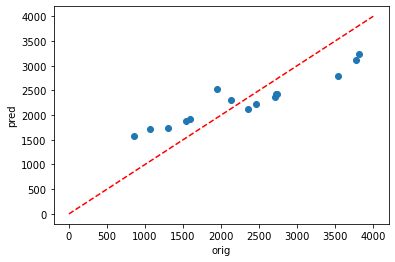

In [40]:
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('orig')
plt.ylabel('pred')
ident = [0, 4000]
plt.plot(ident,ident,'r--')

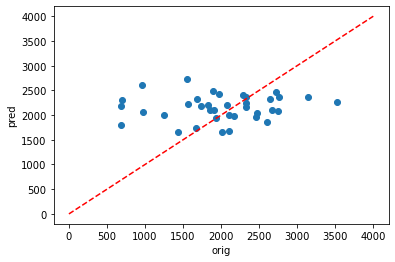

In [41]:
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('orig')
plt.ylabel('pred')
ident = [0, 4000]
plt.plot(ident,ident,'r--')

In [42]:
# Get numerical feature importances
importances = list(rfReg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(variables, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: precip               Importance: 0.28
Variable: t2m                  Importance: 0.25
Variable: snowfall             Importance: 0.24
Variable: snowmelt             Importance: 0.23


([<matplotlib.axis.YTick at 0x7f0a51e69220>,
 [Text(0, 3, 'precipitation'),
  Text(0, 2, 'temperature'),
  Text(0, 1, 'Snowfall'),
  Text(0, 0, 'Snowmelt')])

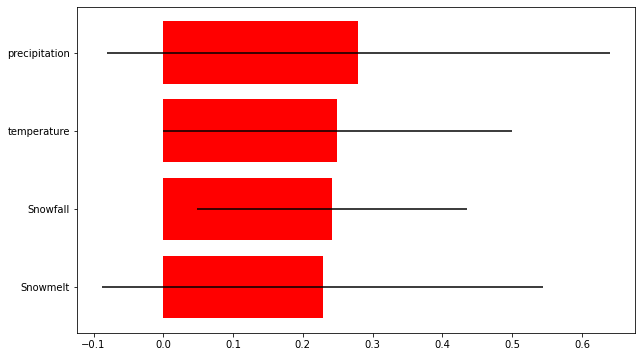

In [45]:
# Plot the importance of different predictors
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)]
ind = np.argsort(impt[0])
plt.rcParams["figure.figsize"] = (10,6)
plt.barh(range(len(variables)),impt[0][ind],color="r", xerr=impt[1][ind], align="center")
plt.yticks([3, 2, 1, 0], ['precipitation', 'temperature', 'Snowfall', 'Snowmelt'])

The final results show that the predictors used in this study are not sufficient to predict frontal velocity at Kronebreen (at least for this short time period). However, all the predictors did have some importance and so are not irrelevant parameters. The relative importance of the different parameters was similar, but snowmelt came out as being the most important predictor.

Full reference for SMB data:


Noël, Brice P Y; Jakobs, Constantijn L; van Pelt, Ward; Lhermitte, Stef; Wouters, Bert; Kohler, Jack; Hagen, Jon Ove; Luks, Bartłomiej; Reijmer, Carleen; van de Berg, Willem Jan; van den Broeke, Michiel R (2020): Annual surface mass balance (SMB) and components of Svalbard glaciers statistically downscaled to 500 m spatial resolution (1958-2018). PANGAEA, https://doi.org/10.1594/PANGAEA.920984